<a href="https://colab.research.google.com/github/Varun9213/Blog_machine_learing/blob/main/Augmentaion_blog_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade
!pip install albumentations --upgrade

In [132]:
from fastai import *
from fastai.vision.all import *
from fastai.imports import *
import cv2, os
from torchvision import transforms as T
from torchvision.transforms import functional as F
import albumentations as A
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

In [3]:
root = Path("/content/data")

In [4]:
os.mkdir(root)

In [5]:
data = download_data(URLs.IMAGENETTE_160)
file_extract(data, dest=root)

In [6]:
root = Path("/content/data/imagenette2-160")

In [7]:
df = pd.read_csv(str(root/"noisy_imagenette.csv"))

In [8]:
df[df.is_valid == False]

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False
...,...,...,...,...,...,...,...
9464,train/n03425413/n03425413_6695.JPEG,n03425413,n03425413,n03425413,n03028079,n03425413,False
9465,train/n03425413/n03425413_7283.JPEG,n03425413,n03425413,n03425413,n03028079,n03425413,False
9466,train/n03425413/n03425413_13096.JPEG,n03425413,n03425413,n03425413,n03425413,n03425413,False
9467,train/n03425413/n03425413_444.JPEG,n03425413,n03425413,n03425413,n01440764,n03000684,False


In [9]:
train_images = get_image_files(root/"train")
val_images = get_image_files(root/"val")

In [10]:
def create_df(paths):
  names = [str(img.name) for img in paths]
  labels = [str(img.parent).split("/")[-1] for img in paths]
  data = np.array([names, labels]).T
  np.random.shuffle(data)
  return pd.DataFrame(data,columns=["image", "label"])

train_df = create_df(train_images)
train_df.head()

,image,label
0,n02102040_8197.JPEG,n02102040
1,ILSVRC2012_val_00020674.JPEG,n03000684
2,n03425413_9079.JPEG,n03425413
3,n03888257_35848.JPEG,n03888257
4,n01440764_8343.JPEG,n01440764


In [11]:
valid_df = create_df(val_images)
valid_df.head()

,image,label
0,n01440764_9031.JPEG,n01440764
1,n02102040_4952.JPEG,n02102040
2,n03028079_21762.JPEG,n03028079
3,n03888257_19960.JPEG,n03888257
4,n03394916_36662.JPEG,n03394916


In [12]:
label_dict = {l:i for i,l in enumerate(train_df["label"].unique())}
label_dict

{'n01440764': 4,
 'n02102040': 0,
 'n02979186': 5,
 'n03000684': 1,
 'n03028079': 9,
 'n03394916': 6,
 'n03417042': 7,
 'n03425413': 2,
 'n03445777': 8,
 'n03888257': 3}

In [160]:
def randAugment(N, M, p, mode="all", cut_out = False):

  shift_x = np.linspace(0,150,10)
  shift_y = np.linspace(0,150,10)
  rot = np.linspace(0,30,10)
  shear = np.linspace(0,10,10)
  sola = np.linspace(0,256,10)
  post = [4,4,5,5,6,6,7,7,8,8]
  cont = [np.linspace(-0.8,-0.1,10),np.linspace(0.1,2,10)]
  bright = np.linspace(0.1,0.7,10)
  shar = np.linspace(0.1,0.9,10)
  cut = np.linspace(0,60,10)

  Aug =[#0 - geometrical
        A.ShiftScaleRotate(shift_limit_x=shift_x[M], rotate_limit=0, shift_limit_y=0, shift_limit=shift_x[M], p=p),
        A.ShiftScaleRotate(shift_limit_y=shift_y[M], rotate_limit=0, shift_limit_x=0, shift_limit=shift_y[M], p=p),
        A.IAAAffine(rotate=rot[M], p=p),
        A.IAAAffine(shear=shear[M], p=p),
        A.InvertImg(p=p),
        #5 - Color Based
        A.Equalize(p=p),
        A.Solarize(threshold=sola[M], p=p),
        A.Posterize(num_bits=post[M], p=p),
        A.RandomContrast(limit=[cont[0][M], cont[1][M]], p=p),
        A.RandomBrightness(limit=bright[M], p=p),
        A.IAASharpen(alpha=shar[M], lightness=shar[M], p=p)]

  if mode == "geo": 
    ops = np.random.choice(Aug[0:5], N)
  elif mode == "color": 
    ops = np.random.choice(Aug[5:], N)
  else:
    ops = np.random.choice(Aug, N)
  
  if cut_out:
    ops.append(A.Cutout(num_holes=8, max_h_size=int(cut[M]), max_w_size=int(cut[M]), p=p))

  transforms = A.Compose(ops)
  return transforms, ops

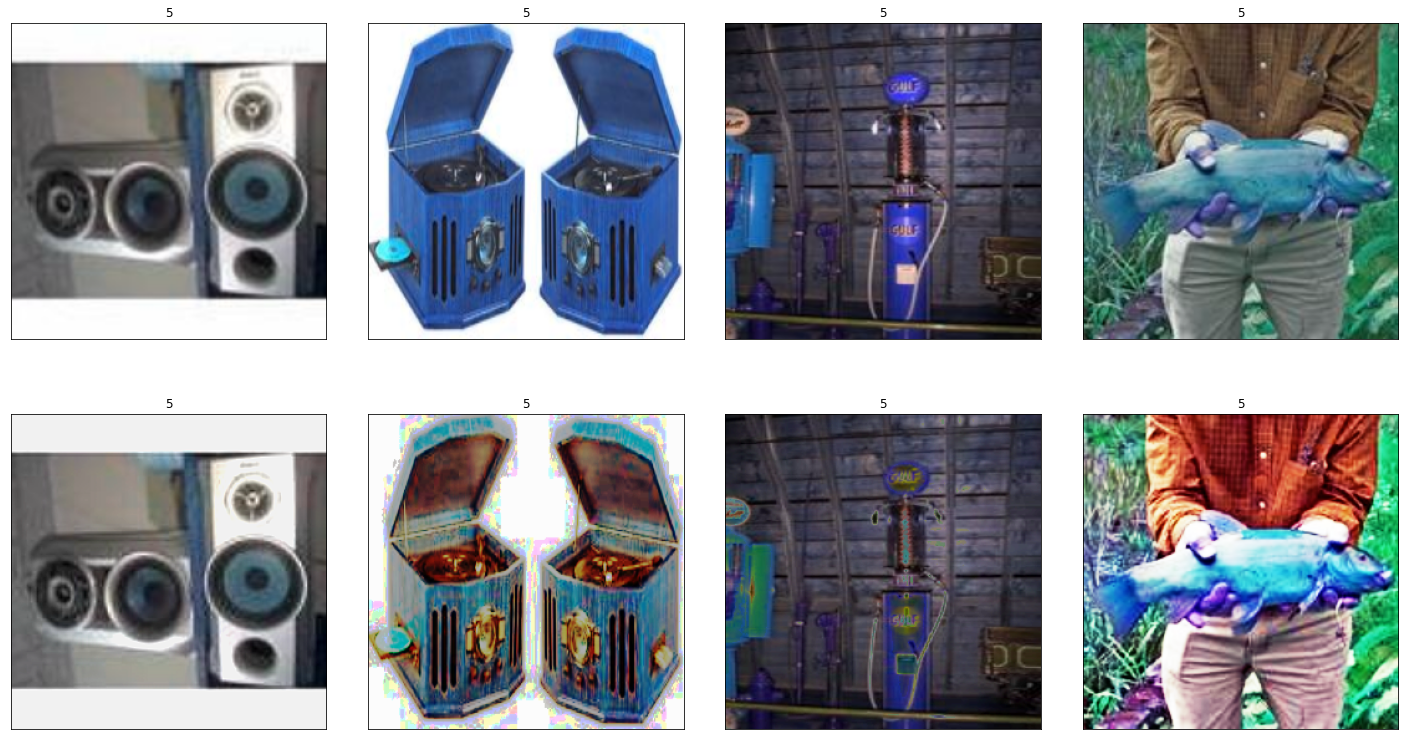

In [14]:
idx = np.random.randint(0,len(train_images)-1, 4)
fig, ax = plt.subplots(2,4, figsize=(20,11))
fig.tight_layout()
M = 5
for i in range(2):
  for j in range(4):
    img = cv2.imread(str(train_images[int(idx[j])]))
    img = cv2.resize(img,(254,254))
    if i == 1:
      transforms, ops = randAugment(2, M, 1, mode="color")
      img = transforms(image=img)["image"]
    ax[i][j].get_xaxis().set_visible(False)
    ax[i][j].get_yaxis().set_visible(False)
    ax[i][j].set_title(str(M))
    ax[i][j].imshow(img)

In [33]:
len(train_df["label"].unique())

10

In [104]:
class ImagenetDataset(torch.utils.data.Dataset):

  def __init__(self, path, df, label_dict, dim = 256, transforms=None):
    self.df = df
    self.transforms = transforms
    self.image_paths = get_image_files(path)
    self.label_dict = label_dict
    self.dim = dim

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    label = self.label_dict[self.df[self.df["image"] == img_path.name]["label"].values[0]]
    img = A.Resize(self.dim, self.dim)(image=img)["image"]
    
    if self.transforms is not None:
      img = self.transforms(image=img)["image"]

    img = F.to_tensor(img)
    label = torch.as_tensor(label)
    label = torch.nn.functional.one_hot(label,len(self.df["label"].unique()))

    return img, label.float()

In [103]:
dataset = ImagenetDataset(root/"train", train_df, label_dict=label_dict)
dataset.__getitem__(1)[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [145]:
def create_dataloaders(root, train_df, valid_df, label_dict, transforms, dim = 256, bs=32):

  data_loaders = {}
  dataset_sizes = {}

  train_dataset = ImagenetDataset(path=root/"train", df=train_df, label_dict=label_dict, dim=dim, transforms=transforms)
  valid_dataset = ImagenetDataset(path=root/"val", df=valid_df, label_dict=label_dict, dim=dim)

  data_loaders["train"] = torch.utils.data.DataLoader(train_dataset, batch_size=bs,shuffle=True, num_workers=4)
  data_loaders["val"] = torch.utils.data.DataLoader(valid_dataset, batch_size=bs,shuffle=False, num_workers=4)

  dataset_sizes["train"] = len(train_dataset)
  dataset_sizes["val"] = len(valid_dataset)

  return data_loaders, dataset_sizes


In [75]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [183]:
def train_model(model, criterion, optimizer, scheduler, aug_mode="all", cut_out=False, max_M=9, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    N=2;M=0;p=0.5

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    
        transforms, ops = randAugment(N=N, M=M, p=p, mode=aug_mode, cut_out=cut_out)
        dataloaders, dataset_sizes = create_dataloaders(root, train_df, valid_df, label_dict, bs=32, transforms=transforms)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(input = outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(input = labels, dim = 1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            elif phase == 'val' and epoch_acc < best_acc:
                stp = int((9-M)*((best_acc-epoch_acc)/best_acc))
                M += max(1,stp)
                M = min(M, max_M)
                if M < max_M:
                  print("Augmentaion Magnitude Changed To : {}\n".format(M))


    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [184]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.fc
model.to(device)
param = model.parameters()
optimizer_ft=torch.optim.Adam(param, lr=0.01)
criterion=nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [185]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, aug_mode="color", max_M=5, num_epochs=16)

Epoch 0/15
----------
train Loss: 0.3456 Acc: 0.1985
val Loss: 0.3019 Acc: 0.2443
Epoch 1/15
----------
train Loss: 0.3114 Acc: 0.1989
val Loss: 0.3334 Acc: 0.1687
Augmentaion Magnitude Changed To : 2

Epoch 2/15
----------
train Loss: 0.2864 Acc: 0.3012
val Loss: 0.2761 Acc: 0.3452
Epoch 3/15
----------
train Loss: 0.2716 Acc: 0.3529
val Loss: 0.3108 Acc: 0.3531
Epoch 4/15
----------
train Loss: 0.2644 Acc: 0.3929
val Loss: 0.3501 Acc: 0.2889
Augmentaion Magnitude Changed To : 3

Epoch 5/15
----------
train Loss: 0.2621 Acc: 0.3909
val Loss: 0.2498 Acc: 0.4326
Epoch 6/15
----------
train Loss: 0.2308 Acc: 0.4952
val Loss: 0.2574 Acc: 0.4349
Epoch 7/15
----------
train Loss: 0.2045 Acc: 0.5729
val Loss: 0.1849 Acc: 0.6222
Epoch 8/15
----------
train Loss: 0.1850 Acc: 0.6179
val Loss: 0.1772 Acc: 0.6408
Epoch 9/15
----------
train Loss: 0.1786 Acc: 0.6338
val Loss: 0.1656 Acc: 0.6670
Epoch 10/15
----------
train Loss: 0.1668 Acc: 0.6664
val Loss: 0.1715 Acc: 0.6517
Augmentaion Magnitude